In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image

from tqdm import tqdm

#from utils import generate_dataset

In [2]:
num_samples = 10000
# read image from file as a binary numpy array
image = Image.open('circle.jpg')
image = image.convert('L')
image = np.array(image)

In [3]:
# find the min and max index that contain black pixels
min_x = np.min(np.where(image == 0)[0])
max_x = np.max(np.where(image == 0)[0])
min_y = np.min(np.where(image == 0)[1])
max_y = np.max(np.where(image == 0)[1])

radius = (max_x - min_x) / 2
center_x = (max_x + min_x) / 2
center_y = (max_y + min_y) / 2

# create a label map that divide the circle into 3 regions (0, 1, 2) depending on the distance to the center
# 0: less or equal to 1/3 radius to the center
# 1: between 1/3 and 2/3 radius to the center
# 2: more than 2/3 radius to the center
label_map = np.zeros_like(image) - 1
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if image[i, j] == 255:
            continue
        dist = np.sqrt((i - center_x) ** 2 + (j - center_y) ** 2)
        if dist <= radius / 3:
            label_map[i, j] = 0
        elif dist <= 2 * radius / 3:
            label_map[i, j] = 1
        else:
            label_map[i, j] = 2
# random sample num_samples pixels from the image
data = np.argwhere(image == 0)
data[:,0], data[:,1] = data[:,1], image.shape[0]-data[:,0]

data = data[np.random.choice(data.shape[0], num_samples, replace=False)]
labels = label_map[data[:,0], data[:,1]]

# normalize the data
data = (data - data.mean(0)) / data.std(0)

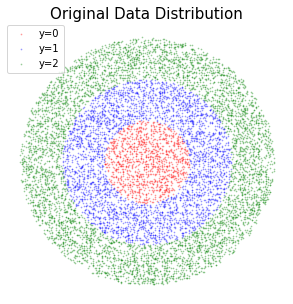

In [4]:
curve = data.T
fig,ax = plt.subplots()
fig.set_size_inches(5,5)
# plot the scatter where label 0, 1, 2 are colored read, blue, green respectively
zeros = curve[:,(labels==0).reshape(-1)]
ones = curve[:,(labels==1).reshape(-1)]
twos = curve[:,(labels==2).reshape(-1)]

axs = ax.scatter(zeros[0,:], zeros[1,:], c='r',s=0.6, alpha=0.3, label='y=0')
axs = ax.scatter(ones[0,:], ones[1,:], c='b', s=0.6, alpha=0.3, label='y=1')
axs = ax.scatter(twos[0,:], twos[1,:], c='g', s=0.6, alpha=0.3, label='y=2')

ax.axis('off')
plt.legend(loc='upper left', borderaxespad=0.)
plt.title('Original Data Distribution', fontsize=15, color='black')
plt.show()

In [6]:
class CircleDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    

In [7]:
data = torch.Tensor(data).float()
labels = torch.Tensor(labels).long().view(-1, 1)
dataset = CircleDataset(data, labels)

In [8]:
# set values for parameters

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


num_steps = 100

# set methods for beta
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

In [9]:
# Calculate alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt

alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


In [10]:
# Forward process

# According to the provement, we can directly sample at any given timesteps (add noise)
# x[0] -> x[t]
def q_x(x_0,t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)


In [11]:
# show the results of forward process (when origin image add noise)
num_shows = 20

In [12]:
# Reverse process

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.y_embeddings = nn.ModuleList(
            [
                nn.Embedding(3, num_units),
                nn.Embedding(3, num_units),
                nn.Embedding(3, num_units),
            ]
        )
        self.t_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )

    def forward(self, x, t, y=None, uncon_rate=0.1):
        """ 生成的过程: 把t的值作为一个embedding,然后和x相加
        下边的循环等价于把每个nn.Embedding分别插入到每个nn.Linear之前
        """
    
        unconditional = torch.rand(1) <= uncon_rate
        for idx in range(len(self.y_embeddings)):
            t_embedding = self.t_embeddings[idx](t)
            x = self.linears[2 * idx](x)
            # with 10% probability, we add the embedding of y and t to x
            if not unconditional and y is not None:
                y = y.reshape(-1)
                y_embedding = self.y_embeddings[idx](y)
                x += y_embedding
            
            x += t_embedding
            x = self.linears[2 * idx + 1](x)

        x = self.linears[-1](x)

        return x

In [13]:
# Inference
def p_sample(model, x, y, t, betas, one_minus_alphas_bar_sqrt, w = 3.0):
    """from x[T] sampling"""
    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = (1 + w) * model(x, t, y, uncon_rate=0.0) - w * model(x, t, uncon_rate=1.0)

    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()

    sample = mean + sigma_t * z

    return (sample)

def p_sample_loop(model, y, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """from x[T] to x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, y, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

In [14]:
# loss function
def diffusion_loss_fn(model, x_0, y, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t
    t = torch.randint(0, n_steps, size=(batch_size // 2,))
    t = torch.cat([t, n_steps - 1 - t], dim=0)
    t = t.unsqueeze(-1)

    # x0的系数
    a = alphas_bar_sqrt[t]

    # eps的系数
    aml = one_minus_alphas_bar_sqrt[t]

    # 生成随机噪音eps
    e = torch.randn_like(x_0)

    # 构造模型的输入
    x = x_0 * a + e * aml

    # 送入模型，得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1), y, uncon_rate=0.1)

    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

Training model...


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.5524


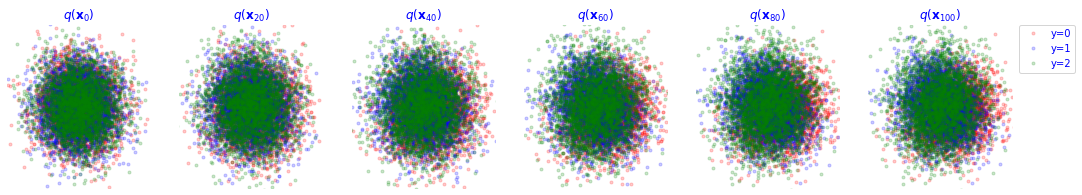

  5%|▌         | 200/4000 [00:22<06:29,  9.76it/s]

Epoch: 200, Loss: 0.5524


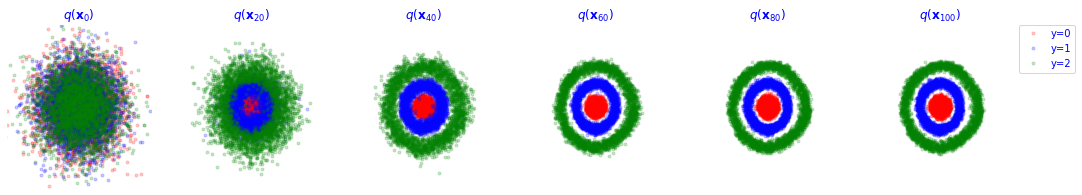

 10%|█         | 400/4000 [00:46<06:35,  9.11it/s]

Epoch: 400, Loss: 0.4862


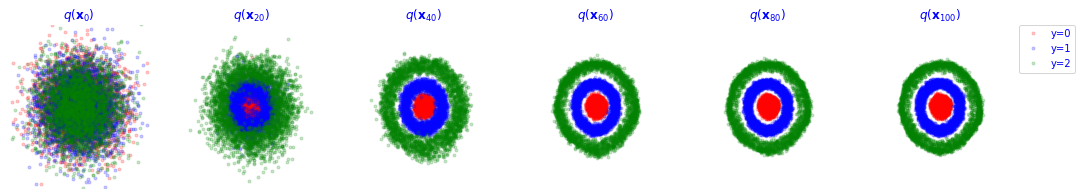

 15%|█▌        | 600/4000 [01:11<06:31,  8.69it/s]

Epoch: 600, Loss: 0.9660


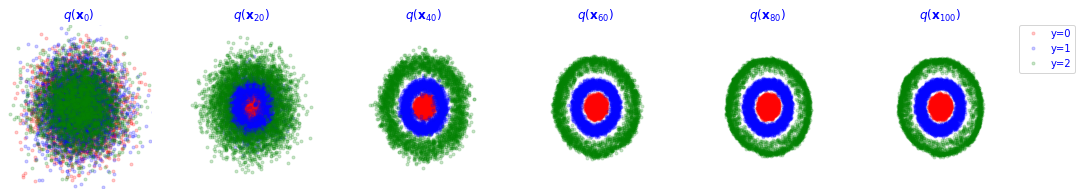

 20%|██        | 800/4000 [01:34<05:37,  9.48it/s]

Epoch: 800, Loss: 0.6362


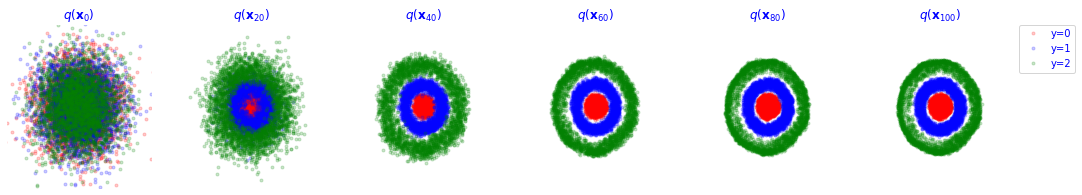

 25%|██▌       | 1000/4000 [01:57<05:36,  8.91it/s]

Epoch: 1000, Loss: 1.0402


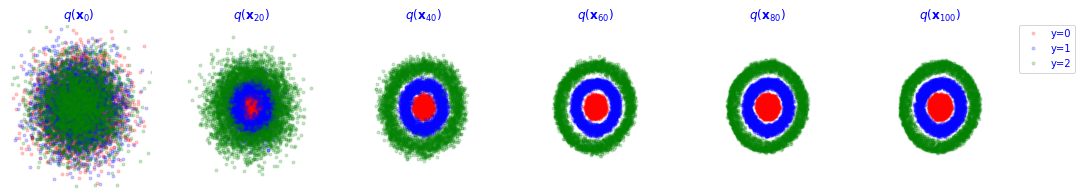

 30%|███       | 1200/4000 [02:20<05:18,  8.78it/s]

Epoch: 1200, Loss: 0.9181


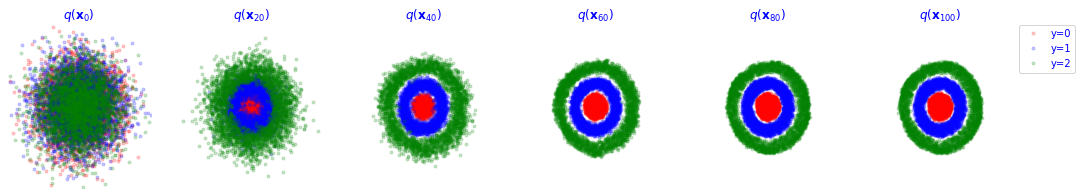

 35%|███▌      | 1400/4000 [02:43<04:37,  9.37it/s]

Epoch: 1400, Loss: 0.4859


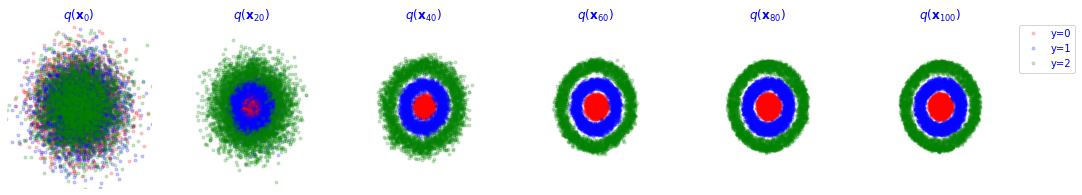

 40%|████      | 1600/4000 [03:07<04:26,  9.02it/s]

Epoch: 1600, Loss: 1.0569


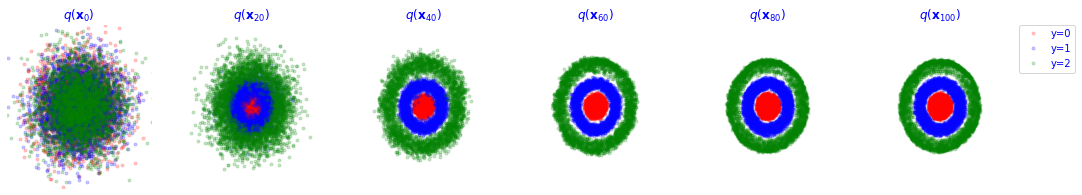

 45%|████▌     | 1800/4000 [03:30<03:48,  9.63it/s]

Epoch: 1800, Loss: 1.0319


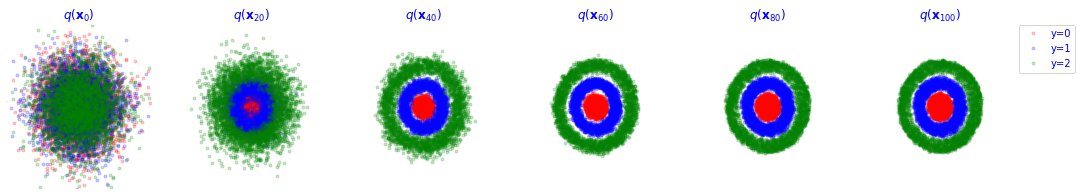

 50%|█████     | 2000/4000 [03:52<03:29,  9.56it/s]

Epoch: 2000, Loss: 0.6912


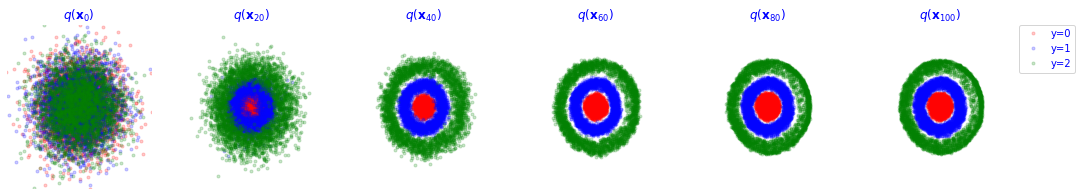

 55%|█████▌    | 2200/4000 [04:15<03:10,  9.46it/s]

Epoch: 2200, Loss: 0.8108


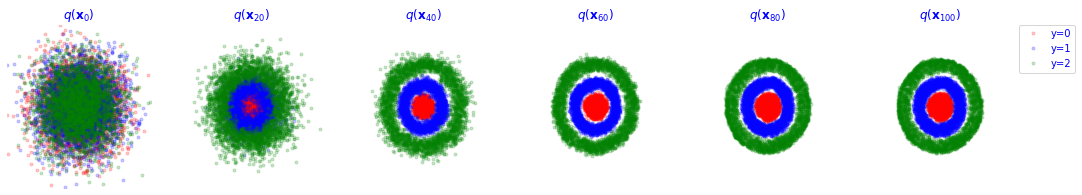

 60%|██████    | 2400/4000 [04:38<03:04,  8.68it/s]

Epoch: 2400, Loss: 0.6983


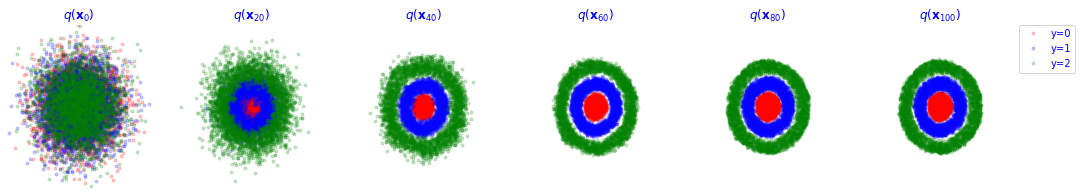

 65%|██████▌   | 2600/4000 [05:02<02:28,  9.46it/s]

Epoch: 2600, Loss: 0.8206


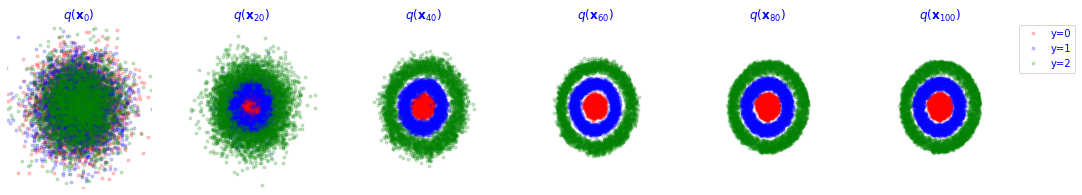

 70%|███████   | 2800/4000 [05:27<02:35,  7.70it/s]

Epoch: 2800, Loss: 0.2957


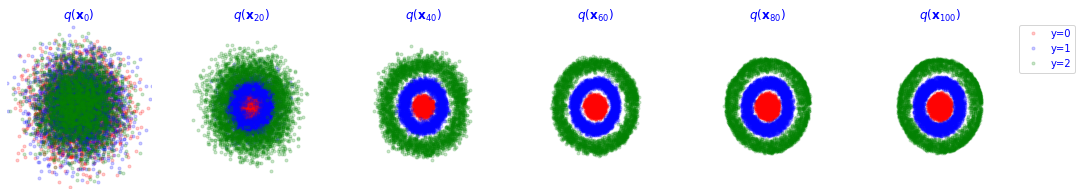

 75%|███████▍  | 2999/4000 [05:48<01:37, 10.26it/s]

Epoch: 3000, Loss: 0.3768


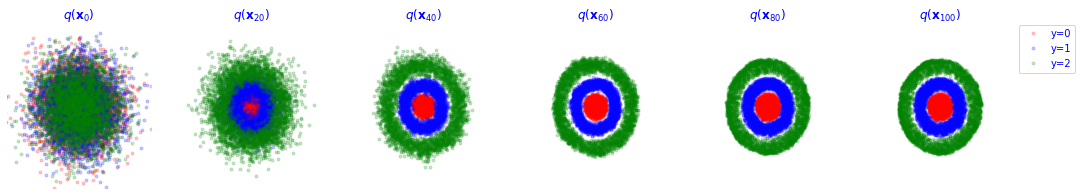

 80%|███████▉  | 3199/4000 [06:09<01:17, 10.34it/s]

Epoch: 3200, Loss: 0.7664


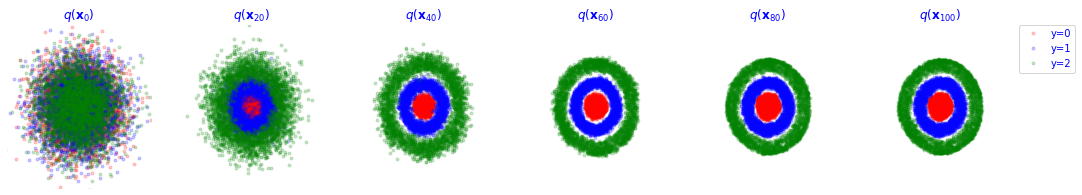

 85%|████████▍ | 3399/4000 [06:30<00:58, 10.28it/s]

Epoch: 3400, Loss: 0.9708


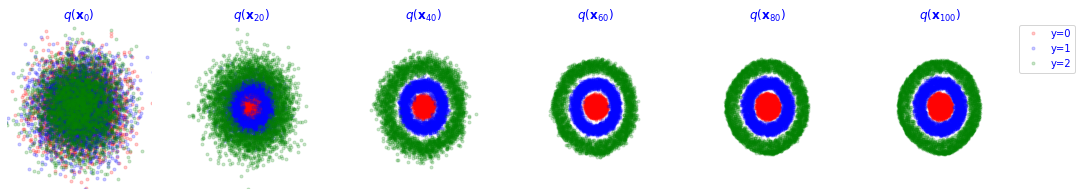

 90%|█████████ | 3600/4000 [06:50<00:37, 10.53it/s]

Epoch: 3600, Loss: 0.6586


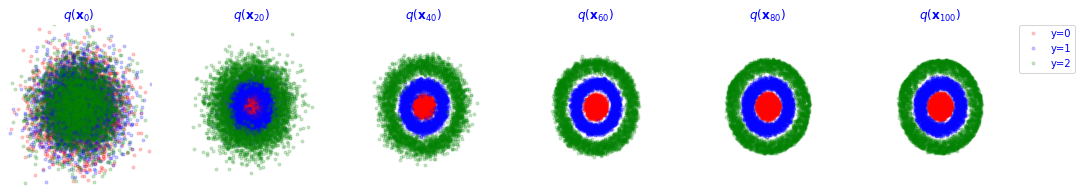

 95%|█████████▍| 3799/4000 [07:10<00:19, 10.54it/s]

Epoch: 3800, Loss: 1.0917


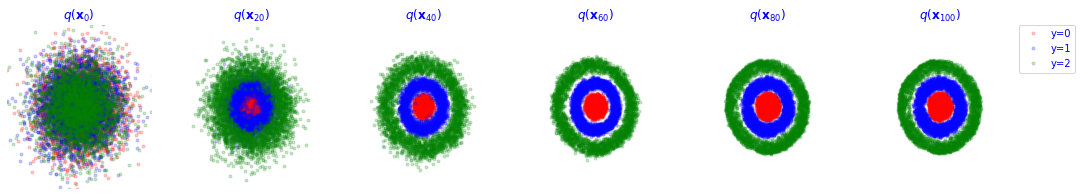

100%|██████████| 4000/4000 [07:31<00:00,  8.86it/s]


In [15]:
# Training model
seed = 1234

print('Training model...')


batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps)  # 输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in tqdm(range(num_epoch)):
    for idx, (batch_x, batch_y) in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, batch_y, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()


    # print loss
    if (t % 200 == 0):
        tqdm.write('Epoch: {}, Loss: {:.4f}'.format(t, loss.item()))
        # random choose 0 or 1 
        y0 = torch.tensor([0])
        y1 = torch.tensor([1])
        y2 = torch.tensor([2])
        shape = (data.shape[0]//3, data.shape[1])
        x_seq0 = p_sample_loop(model, y0, shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        x_seq1 = p_sample_loop(model, y1, shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        x_seq2 = p_sample_loop(model, y2, shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        
        fig, axs = plt.subplots(1, 6, figsize=(18, 3))
        scatter_range = [-3.5, 3.5]
        for i in range(0, 6):
            cur_x0 = x_seq0[i * 20].detach()
            cur_x1 = x_seq1[i * 20].detach()
            cur_x2 = x_seq2[i * 20].detach()
            # plot on the same scatter figure with different color
            axs[i].plot(cur_x0[:, 0], cur_x0[:, 1], '.', color='red',alpha=0.2, label='y=0')
            axs[i].plot(cur_x1[:, 0], cur_x1[:, 1], '.', color='blue',alpha=0.2, label='y=1')
            axs[i].plot(cur_x2[:, 0], cur_x2[:, 1], '.', color='green',alpha=0.2, label='y=2')
            # set the range of the scatter figure
            axs[i].set_xlim(scatter_range)
            axs[i].set_ylim(scatter_range)
            axs[i].set_axis_off();
            axs[i].set_title('$q(\mathbf{x}_{' + str(i * 20) + '})$')
        # fix the legend position
        axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.show()

In [16]:
%%capture
# Generating the forward image sequence.
imgs = []
# Generating the reserve diffusion sequense
for i in range(100):
    plt.clf()
    plt.figure(figsize=(6, 6))
    scatter_range = [-2.5, 2.5]
    cur_x0 = x_seq0[i].detach()
    cur_x1 = x_seq1[i].detach()
    cur_x2 = x_seq2[i].detach()
    plt.plot(cur_x0[:, 0], cur_x0[:, 1], '.', color='red',alpha=0.3, label='y=0')
    plt.plot(cur_x1[:, 0], cur_x1[:, 1], '.', color='blue',alpha=0.3, label='y=1')
    plt.plot(cur_x2[:, 0], cur_x2[:, 1], '.', color='green',alpha=0.3, label='y=2')
    plt.xlim(scatter_range)
    plt.ylim(scatter_range)
    plt.legend(loc='upper left', borderaxespad=0.)
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='jpg', bbox_inches='tight')
    img = Image.open(img_buf)
    imgs.append(img)

imgs[0].save("cfg_ddpm.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0,border=0)

This gif shows the progress of how the picture into noise, and then reserve.  
![output](cfg_ddpm.gif)